In [27]:
%matplotlib notebook
import beamsolve as bs
from beam_solver import beamsolve as bs
from beam_solver import beam_utils as bt
import catdata as cd
from beam_solver.data import DATA_PATH
import numpy as np
import pylab
import glob
import pickle
import h5py
import os
from collections import OrderedDict

In [67]:
catd = cd.catData()
catd.read_hdf5('srcd_xx.h5')

In [7]:
beamfits = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
beam_xx = bt.get_fitsbeam(beamfits, 151e6, 'xx')

Casting complex values to real discards the imaginary part


In [69]:
corrflux_xx = catd.calc_catalog_flux(beam_xx, 'xx')
print corrflux_xx.shape

(120,)


In [11]:
bms_xx = bs.BeamSolveBase(cat=catd)
bms_xx.construct_linear_sys(mflux = corrflux_xx)
sol_xx = bms_xx.solve(solver='Linear')

Solving 0/1
Time Elapsed: 0.98 seconds


In [13]:
obsbeam_xx = bs.eval_linear_sol(sol_xx, 60)

<IPython.core.display.Javascript object>


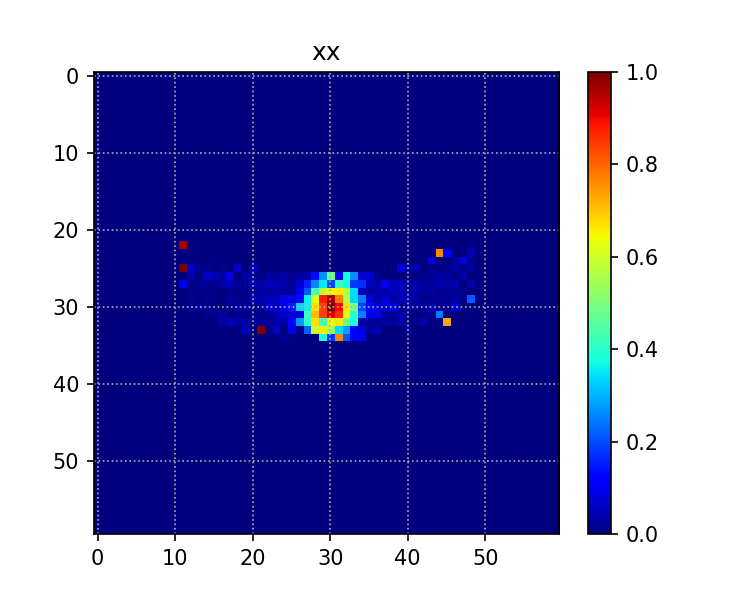

In [16]:
pylab.figure(figsize=(5,4))
pylab.subplot(111)
pylab.title('xx')
pylab.imshow(obsbeam_xx.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')

In [17]:
# beamfile
beamfits = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')

# xx fitsfiles
fitsfile1_xx = os.path.join(DATA_PATH, '2458115.23736.xx.fits')
fitsfile2_xx = os.path.join(DATA_PATH, '2458115.24482.xx.fits')
fitsfiles_xx = [fitsfile1_xx, fitsfile2_xx]

# yy fitsfiles
fitsfile1_yy = os.path.join(DATA_PATH, '2458115.23736.yy.fits')
fitsfile2_yy = os.path.join(DATA_PATH, '2458115.24482.yy.fits')
fitsfiles_yy = [fitsfile1_yy, fitsfile2_yy]

# right ascension and declination values
ras = [30.01713089, 27.72922349, 36.75248962, 34.2415497, 78.3776346, 74.03785837]
decs = [-30.88211818, -29.53377208, -30.63958257, -29.93990039, -30.48595805, -30.08651873]

In [18]:
catd = cd.catData()
catd.gen_catalog(fitsfiles_xx, ras, decs)

In [19]:
corrflux_xx = catd.calc_catalog_flux(beam_xx, 'xx')

In [20]:
bms_xx = bs.BeamSolveBase(cat=catd)
bms_xx.construct_linear_sys(mflux = corrflux_xx)
sol_xx = bms_xx.solve(solver='Linear')

Solving 0/1
Time Elapsed: 0.01 seconds


<IPython.core.display.Javascript object>


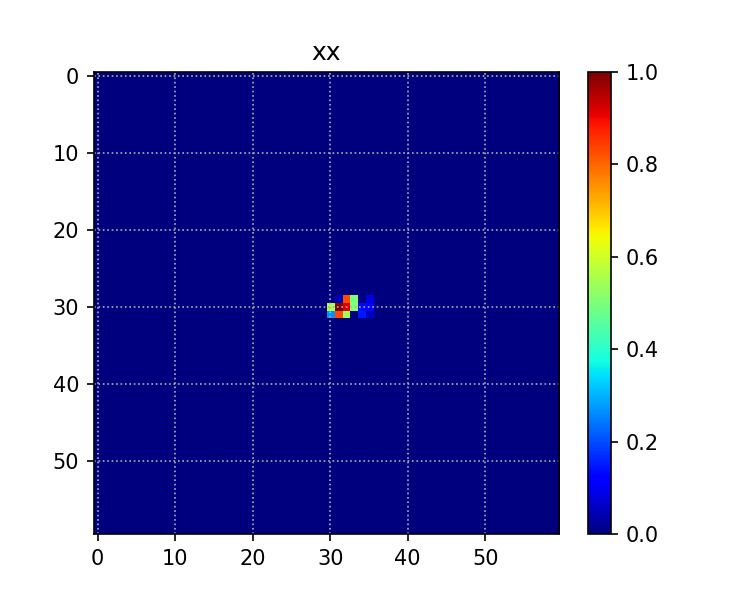

In [21]:
obsbeam_xx = bs.eval_linear_sol(sol_xx, 60)
pylab.figure(figsize=(5,4))
pylab.subplot(111)
pylab.title('xx')
pylab.imshow(obsbeam_xx.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')

In [100]:
def get_weights(azalts, theta=0, flip=1):
        """
        Returns the four closest pixels to the azimuth-altitude values on the 2D
        grid.

        Parameters
        ----------
        azalts : ndarray
            2D array consisting of the azimuth and alitutes values in degrees.
        """

        # selecting the four closest pixels
        bm_pix = 31
        tx, ty, tz = aipy.coord.azalt2top([azalts[0, :] * np.pi/180., azalts[1, :] * np.pi/180.])
        tx, ty = np.dot(rotate_mat(theta), np.array([tx, ty]))
        tx = flip * tx
        tx_px = tx * 0.5 * bm_pix + 0.5 * bm_pix
        ty_px = ty * 0.5 * bm_pix + 0.5 * bm_pix
        tx_px0 = np.floor(tx_px).astype(np.int)
        tx_px1 = np.clip(tx_px0 + 1, 0, bm_pix -1)
        ty_px0 = np.floor(ty_px).astype(np.int)
        ty_px1 = np.clip(ty_px0 + 1, 0, bm_pix -1)

        x0y0 = np.array([tx_px0, ty_px0], dtype=np.int)
        x0y1 = np.array([tx_px0, ty_px1], dtype=np.int)
        x1y0 = np.array([tx_px1, ty_px0], dtype=np.int)
        x1y1 = np.array([tx_px1, ty_px1], dtype=np.int)

        # defining the weights
        fx = tx_px - tx_px0
        fy = ty_px - ty_px0
        w0 = (1 - fx) * (1 - fy)
        w1 = fx * (1 - fy)
        w2 = (1 - fx) * fy
        w3 = fx * fy
        ps = [x0y0, x0y1, x1y0, x1y1]
        ws = [w0, w1, w2, w3]

        return ps, ws
    
def _mk_key(pixel, srcid, timeid):
        """
        Generates key to represent the beam pixel which include the source id,
        timestamp and pixel.

        Parameters
        ----------
        pixel : int
            Pixel from the 2D grid beam.

        srcid : int
            Source identity.

        timeid : int
            Time identity or timestamps.

        Returns
        -------
            String corresponding the given parameters.
        """

        return 'w%d_s%d_t%d' % (pixel, srcid, timeid)
    
def unravel_pix(ndim, coord):
        """
        Returns the unraveled/flattened pixel of any (m, n) position
        or coordinates on any square 2D-grid

        Parameters
        ----------
        coord : tuple of int
            Coordinates (m, n) for which to calculate the  flattened index.

        Returns
        -------
        index of the flattened array corresponding to the coordinates (m, n).
        """

        return (coord[0] * ndim) + coord[1]
    
def rotate_mat(theta):
        """
        Rotate coordinates or pixels by theta degrees

        Parameters
        ----------
        theta : float
            Angle by which the coordinates or pixels will be rotated.
        """

        return np.array([[np.cos(theta), -1*np.sin(theta)], [np.sin(theta), np.cos(theta)]])

In [70]:
nfits = catd.Nfits
nsrcs = catd.Nsrcs

bm_pix = 60
obs_vals = catd.data_array[0]
eqs = OrderedDict()
consts = OrderedDict()
theta = [0]
flip = [1]
for i in xrange(nsrcs):
    for th in theta:
        for fl in flip:
            ps, ws = get_weights(catd.azalt_array[:, i, :], th, fl)
            for j in xrange(nfits):
                I_s = obs_vals[i, j]
                if np.isnan(I_s): continue
                c = {_mk_key(unravel_pix(bm_pix, (ps[p][0, j], ps[p][1, j])), i, j): ws[p][j] for p in xrange(4)}
                eq = ' + '.join([_mk_key(unravel_pix(bm_pix, (ps[p][0, j], ps[p][1, j])), i, j)
                       + '*b%d'%(unravel_pix(bm_pix, (ps[p][0, j], ps[p][1, j])))  for p in xrange(4)])
                eqs[eq] = I_s / corrflux_xx[i]
                consts.update(c)

eqs_noise = {k:v for k,v in eqs.items()}
ls = linsolve.LinearSolver(eqs_noise, **consts)
sol = ls.solve(verbose=True)

Solving 0/1


In [71]:
interp2d = np.zeros((bm_pix**2))
for key in sol.keys():
    px = int(key.strip('b'))     
    interp2d[px] = sol.get(key)

<IPython.core.display.Javascript object>


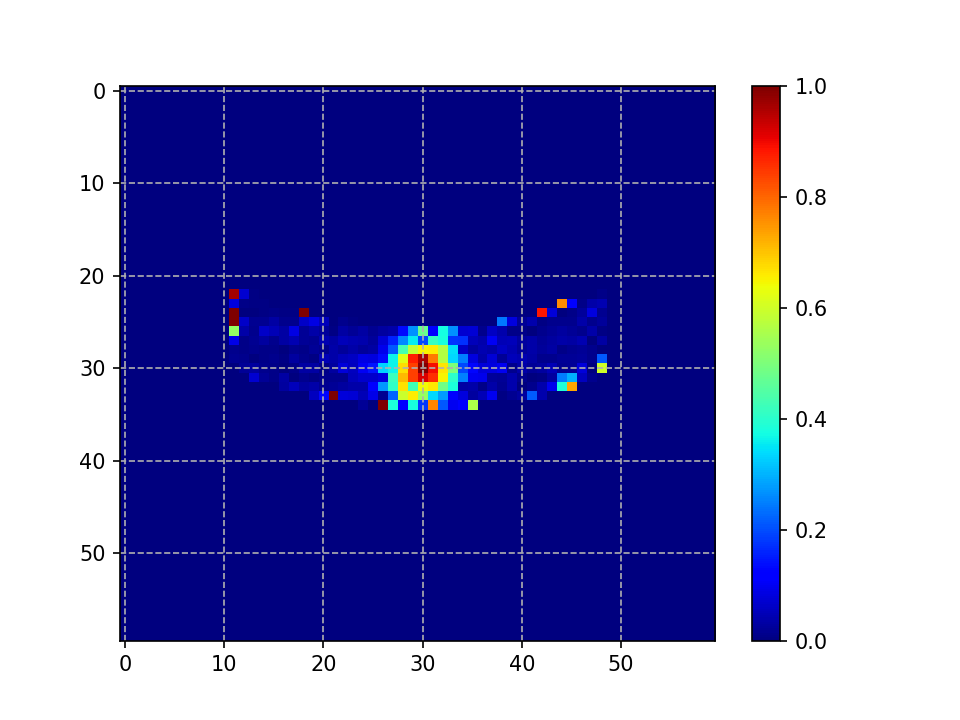

In [72]:
pylab.subplot(111)
im = pylab.imshow(np.abs(interp2d.reshape(bm_pix,bm_pix).T), aspect='auto', cmap='jet', vmin=0, vmax=1)
pylab.colorbar(im)
pylab.grid(ls='dashed')

In [50]:
import beamsolve as bs

In [59]:
bms = bs.BeamSolve(catd)
bmss = bms.beamsolver()
bmss.construct_linear_sys(catalog_flux=corrflux_xx)
sol = bmss.ls.solve(verbose=True)

Solving 0/1


In [58]:
sol

{'b1830': 0.5584261171404349,
 'b1831': 0.26913886498949624,
 'b1889': 0.04863810364924108,
 'b1890': 1.373974858372824,
 'b1891': 0.8315742684182276,
 'b1949': 0.8294909069769911,
 'b1950': 0.9191331422404381,
 'b1951': 0.5354956769430794,
 'b2009': 0.5020695734052174,
 'b2010': 0.5091591218152042,
 'b2011': -0.0427608187057347,
 'b2069': 0.01018903907285744,
 'b2070': 0.13384886101088123,
 'b2071': 0.1505245851153983,
 'b2129': 0.08518829918560422,
 'b2130': 0.11264849587861393,
 'b2131': 0.05808250337219264,
 'b2189': 0.0021954258753293203,
 'b2190': 0.00273853701193084}

In [56]:
sol

{'b1830': 0.5584261171404342,
 'b1831': 0.2691388649894959,
 'b1889': 0.048638103649241295,
 'b1890': 1.3739748583728224,
 'b1891': 0.8315742684182267,
 'b1949': 0.8294909069769943,
 'b1950': 0.9191331422404394,
 'b1951': 0.5354956769430789,
 'b2009': 0.5020695734052162,
 'b2010': 0.5091591218152038,
 'b2011': -0.04276081870573403,
 'b2069': 0.010189039072857523,
 'b2070': 0.1338488610108808,
 'b2071': 0.15052458511539749,
 'b2129': 0.085188299185605,
 'b2130': 0.11264849587861381,
 'b2131': 0.05808250337219212,
 'b2189': 0.002195425875329324,
 'b2190': 0.0027385370119308297}

<IPython.core.display.Javascript object>


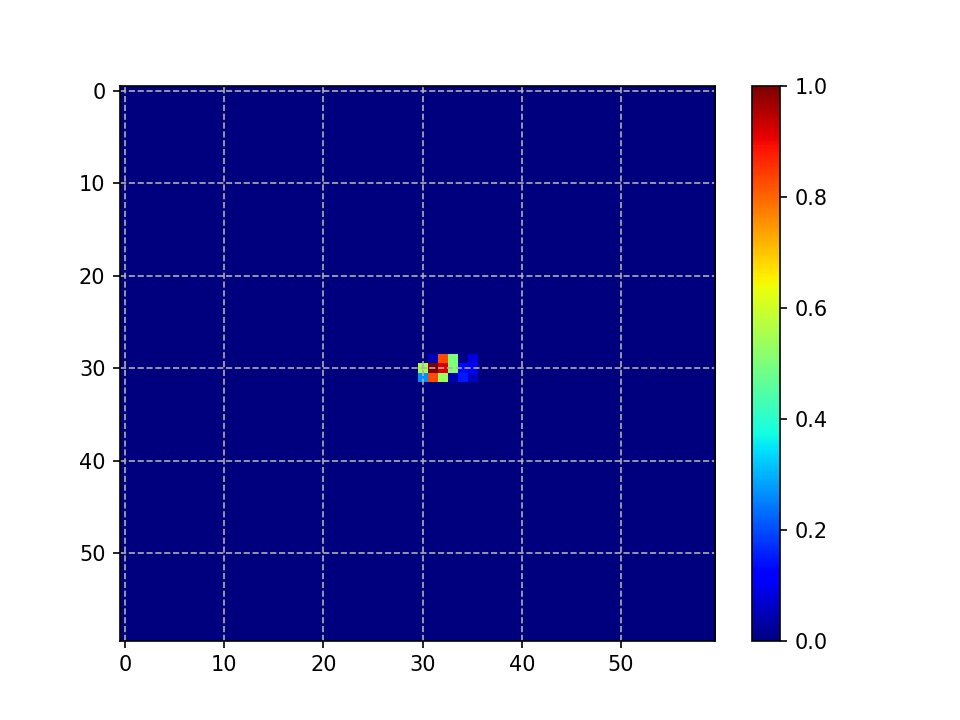

In [66]:
obsbeam = bmss.eval_sol(sol)
pylab.subplot(111)
im = pylab.imshow(np.abs(obsbeam.T), aspect='auto', cmap='jet', vmin=0, vmax=1)
pylab.colorbar(im)
pylab.grid(ls='dashed')

# Simulation

In [74]:
def recenter(a, c):
    """Slide the (0,0) point of matrix a to a new location tuple c.  This is
    useful for making an image centered on your screen after performing an
    inverse fft of uv data."""
    s = a.shape
    c = (c[0] % s[0], c[1] % s[1])
    if np.ma.isMA(a):
        a1 = np.ma.concatenate([a[c[0]:], a[:c[0]]], axis=0)
        a2 = np.ma.concatenate([a1[:,c[1]:], a1[:,:c[1]]], axis=1)
    else:
        a1 = np.concatenate([a[c[0]:], a[:c[0]]], axis=0)
        a2 = np.concatenate([a1[:,c[1]:], a1[:,:c[1]]], axis=1)
    return a2

def get_LM(dim, center=(0,0), res=1):
        """Get the (l,m) image coordinates for an inverted UV matrix."""
        M,L = np.indices((dim, dim))
        L,M = np.where(L > dim/2, dim-L, -L), np.where(M > dim/2, M-dim, M)
        L,M = L.astype(np.float32)/dim/res, M.astype(np.float32)/dim/res
        mask = np.where(L**2 + M**2 >= 1, 1, 0)
        L,M = np.ma.array(L, mask=mask), np.ma.array(M, mask=mask)
        return recenter(L, center), recenter(M, center)

def get_top(dim, center=(0,0), res=1):
    """Return the topocentric coordinates of each pixel in the image."""
    x,y = get_LM(dim, center, res)
    z = np.sqrt(1 - x**2 - y**2)
    return x,y,z

In [75]:
bm_pix = 31
bm_true = np.zeros((bm_pix, bm_pix), dtype=float)
bmx, bmy = np.indices(bm_true.shape)
mu = 15.; sigma=3.
bm_true = np.exp(-((bmx-mu)**2 + (bmy-mu)**2)/ (2 * sigma**2))
tx0, ty0, tz0 = get_top(bm_pix, center=(15, 15), res=0.5)
tx00, ty00, tz00 = tx0.flatten(), ty0.flatten(), tz0.flatten()
indices = np.arange(bm_pix**2)
azs, alts = aipy.coord.top2azalt([np.array(tx0[:,:]), np.array(ty0[:,:]), np.array(tz0[:,:])])
azs = np.rad2deg(azs); alts= np.rad2deg(alts)
_sh = azs.shape

In [78]:
catd_copy = copy.deepcopy(catd)
new_data = np.zeros((1, _sh[0], _sh[1]))
fluxvals = np.random.random(_sh[0]) + 10
for i in range(_sh[0]):
        tx, ty, tz = aipy.coord.azalt2top([np.deg2rad(catd_copy.azalt_array[0, i, :]), np.deg2rad(catd_copy.azalt_array[1, i, :])])
        tx_px = tx * 0.5*bm_pix + 0.5*bm_pix
        tx_px0 = np.floor(tx_px).astype(np.int)
        tx_px1 = np.clip(tx_px0+1,0,bm_pix-1)#tx_px0 + 1
        fx = tx_px - tx_px0
        ty_px = ty * 0.5*bm_pix + 0.5*bm_pix
        ty_px0 = np.floor(ty_px).astype(np.int)
        ty_px1 = np.clip(ty_px0+1,0,bm_pix-1)#ty_px0 + 1
        fy = ty_px - ty_px0
        x0y0 = np.array([tx_px0, ty_px0], dtype=np.int)
        x0y1 = np.array([tx_px0, ty_px1], dtype=np.int)
        x1y0 = np.array([tx_px1, ty_px0], dtype=np.int)
        x1y1 = np.array([tx_px1, ty_px1], dtype=np.int)

        w0 = ((1 - fx) * (1 - fy))**(-1)
        w1 = (fx * (1 - fy))**(-1)
        w2 = ((1 - fx) * fy)**(-1)
        w3 = (fx * fy)**(-1)

        for j in range(_sh[1]):
            weights = w0[j] + w1[j] + w2[j] + w3[j]
            A_s = (bm_true[tx_px0[j],ty_px0[j]] * w0[j] + bm_true[tx_px0[j],ty_px1[j]] * w1[j] + bm_true[tx_px1[j],ty_px0[j]] * w2[j] + bm_true[tx_px1[j], ty_px1[j]] * w3[j])/weights
            new_data[0, i, j] = A_s * fluxvals[i]

In [84]:
azalt_array = np.zeros((2, _sh[0], _sh[1]))
azalt_array[0, :, :] = azs
azalt_array[1, :, :] = alts
catd_copy.azalt_array = azalt_array
catd_copy.data_array = new_data
catd_copy.Nfits = _sh[1]
catd_copy.Nsrcs = _sh[0]

In [83]:
print catd_copy.data_array.shape
print catd_copy.azalt_array.shape

(1, 31, 31)
(2, 31, 31)


In [103]:
nfits = catd_copy.Nfits
nsrcs = catd_copy.Nsrcs

bm_pix = 31
obs_vals = catd_copy.data_array[0]
print obs_vals.shape, nfits, nsrcs
eqs = OrderedDict()
consts = OrderedDict()
theta = [0]
flip = [1]
for i in xrange(nsrcs):
    for th in theta:
        for fl in flip:
            ps, ws = get_weights(catd_copy.azalt_array[:, i, :], th, fl)
            for j in xrange(nfits):
                I_s = obs_vals[i, j]
                if np.isnan(I_s): continue
                c = {_mk_key(unravel_pix(bm_pix, (ps[p][0, j], ps[p][1, j])), i, j): ws[p][j] for p in xrange(4)}
                eq = ' + '.join([_mk_key(unravel_pix(bm_pix, (ps[p][0, j], ps[p][1, j])), i, j)
                       + '*b%d'%(unravel_pix(bm_pix, (ps[p][0, j], ps[p][1, j])))  for p in xrange(4)])
                eqs[eq] = I_s / fluxvals[i]
                consts.update(c)

eqs_noise = {k:v for k,v in eqs.items()}
ls = linsolve.LinearSolver(eqs_noise, **consts)
sol = ls.solve(verbose=True)

(31, 31) 31 31
9.154127036162835
8.878460806342083
10.140430063917385
10.379112183582706
10.039544447669467
9.306225412545821
9.065464185345823
7.704230506711111
5.975696022525183
5.970674298228748
4.286542557240707
2.8299488955660244
1.6893764355990704
0.9402866949309671
1.0873693191691889
0.5650872165924125
0.6542788549681825
0.11398142871474021
0.15813806870759672
0.20902541484731937
0.08774924197909872
0.03320795537071288
0.01343703391834748
0.02020202427406442
0.02803082557884245
0.0019856228555746045
0.0035673824028496495
0.005428264431316702
0.00752856022728417
0.0004459485527707635
0.0007450884093406917
9.636867959642768
10.582448948408288
10.211198464441503
10.049898787215403
8.926659087917951
8.694316989545786
7.092290207665797
5.3014147083046375
5.317780966947614
3.7154200582602592
3.8002027142426904
2.4792919570255405
0.6867804147153739
0.8287938432471946
0.4312320933373239
0.5183680526232934
0.24912696385539373
0.2953315356234057
0.0453253462996634
0.0649781768879957
0.087

7.214807356856051
4.303514544901668
4.340206614959936
2.925344637042747
3.02339589520973
1.9311419817698108
1.1406603850865635
1.219859271791102
0.6684197384786434
0.05565841851626327
0.07442582102831094
0.09484053089867196
0.11407559401332691
0.1503975037023973
0.42478638323016155
1.0016303738781687
1.1359333554793751
2.2346011686820306
2.4459137612059623
2.5844091059414858
2.644944575669755
4.505561267545027
6.700276372232117
6.568720566711966
8.53012209845151
9.849123405425093
9.519597820583948
9.836144478136847
9.514570758451013
8.914746909549622
7.583123060235174
7.465097614724977
5.850457526802351
5.846459648497407
2.6251360416220093
1.5549343394655961
1.7639262734566037
0.9895415363407295
1.135147715518895
0.5911515857015921
0.08671213290495514
0.042965346961489265
0.1559426194774603
0.19616998393097643
0.5266332764662043
0.6093412685355467
1.351600768891611
0.7334695991226737
1.6764704842869154
1.755789730964269
3.315355527417246
5.441831823697073
5.403702934098219
7.6804229764

In [96]:
sol

{'b828': -0.1663886801433302,
 'b829': -1.7887300374641026,
 'b824': -0.9350271937305111,
 'b825': 0.06910075918341851,
 'b826': -0.6401647246249909,
 'b827': -0.004298448238537755,
 'b820': -23.256706152720653,
 'b821': -13.761656327440257,
 'b822': -1.027490373498471,
 'b823': 0.7554856799575378,
 'b989': 0.06650250448543726,
 'b988': 0.0650340727982103,
 'b965': -0.005071918601444736,
 'b983': -0.05192608079885219,
 'b982': -0.2595268578062754,
 'b981': -0.061083785825858605,
 'b980': -0.8318892781458498,
 'b987': 0.00039719166802471353,
 'b986': -0.19220916143211253,
 'b985': -0.02909901808193016,
 'b984': -0.31279020877188446,
 'b1827': 0.0008604684154986889,
 'b1770': 0.0011413462157661147,
 'b1172': 0.3144040490885129,
 'b910': -0.4835210508301256,
 'b858': 0.21599951617135754,
 'b912': -1.6508469933852474,
 'b913': 23.671314356393065,
 'b914': -33.91268720975236,
 'b915': -0.7105622158381009,
 'b916': -2.260065028536808,
 'b917': 0.6663566399683476,
 'b918': -0.998680544240463,

In [104]:
interp2d = np.zeros((bm_pix**2))
print interp2d.shape, 31 * 31
for key in sol.keys():
    px = int(key.strip('b'))     
    interp2d[px] = sol.get(key)

(961,) 961


<IPython.core.display.Javascript object>


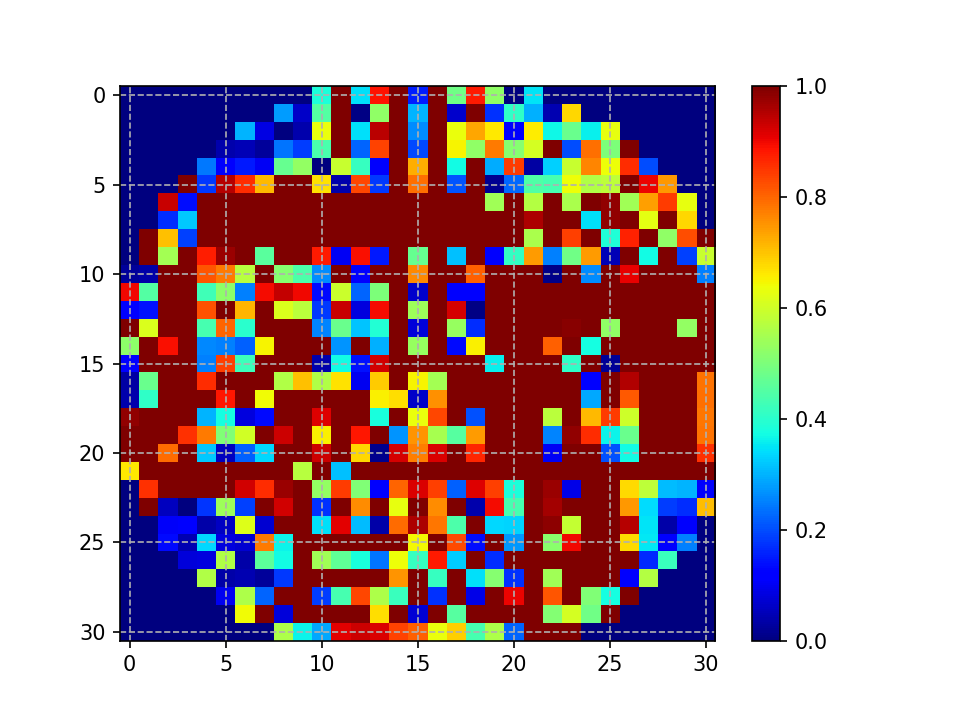

In [105]:
pylab.subplot(111)
im = pylab.imshow(np.abs(interp2d.reshape(bm_pix,bm_pix).T), aspect='auto', cmap='jet', vmin=0, vmax=1)
pylab.colorbar(im)
pylab.grid(ls='dashed')